<a href="https://colab.research.google.com/github/castudil/bacteria-multi-label/blob/main/multilabel_bac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries used

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain
from sklearn.metrics import (f1_score, multilabel_confusion_matrix,
                             accuracy_score, hamming_loss, jaccard_score, make_scorer)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import SVC

from joblib import dump, load

In [2]:
os.chdir("..")

In [3]:
train_file = "data/processed/binned/train_s_aureus_driams_bin5.csv"
train_bac = pd.read_csv(train_file)
train_bac

,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,...,9965,9970,9975,9980,9985,9990,9995,Oxacillin,Clindamycin,Fusidic acid
0,0.021589,0.022946,0.020381,0.019762,0.022195,0.020017,0.020972,0.023774,0.026180,0.022159,...,0.033513,0.041287,0.036239,0.030211,0.035161,0.033998,0.038221,0.0,0.0,0.0
1,0.009301,0.008272,0.008337,0.007711,0.007782,0.007348,0.007808,0.007108,0.006898,0.008332,...,0.023975,0.026137,0.021943,0.024854,0.029517,0.022439,0.025007,0.0,0.0,0.0
2,0.025274,0.019463,0.019516,0.020692,0.018069,0.018431,0.023269,0.020666,0.020079,0.020810,...,0.025799,0.021951,0.029973,0.025818,0.029609,0.024297,0.027897,0.0,0.0,0.0
3,0.020099,0.020638,0.019760,0.018159,0.018335,0.022901,0.065560,0.026733,0.020303,0.027320,...,0.050939,0.053343,0.051328,0.053429,0.050428,0.047393,0.054734,0.0,0.0,0.0
4,0.008984,0.008043,0.013672,0.010317,0.009059,0.010720,0.013516,0.008752,0.008767,0.007783,...,0.158928,0.170674,0.173528,0.182519,0.194263,0.213917,0.213849,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,0.054429,0.048667,0.045425,0.040572,0.050953,0.044444,0.042166,0.045230,0.046186,0.043899,...,0.023866,0.023817,0.022983,0.019162,0.027157,0.020898,0.019744,0.0,1.0,0.0
2820,0.130637,0.110645,0.120394,0.122708,0.126439,0.110826,0.111382,0.126231,0.159306,0.115032,...,0.091067,0.087054,0.071257,0.082721,0.079852,0.079148,0.085198,0.0,1.0,0.0
2821,0.027519,0.042642,0.042732,0.042214,0.037931,0.038325,0.048778,0.059403,0.038095,0.046506,...,0.004087,0.005437,0.004977,0.004079,0.004673,0.006618,0.006707,0.0,0.0,0.0
2822,0.005901,0.004834,0.007536,0.004969,0.005234,0.004168,0.004910,0.003472,0.004161,0.004788,...,0.035666,0.038966,0.042347,0.038167,0.031830,0.037942,0.044095,1.0,1.0,0.0


In [4]:
test_file = "data/processed/binned/test_s_aureus_driams_bin5.csv"
test_bac = pd.read_csv(test_file)
test_bac

,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,...,9965,9970,9975,9980,9985,9990,9995,Oxacillin,Clindamycin,Fusidic acid
0,0.041853,0.035847,0.044014,0.038222,0.035438,0.039194,0.045455,0.036699,0.030814,0.039204,...,0.237908,0.260413,0.258291,0.247243,0.257622,0.248413,0.259787,0.0,0.0,0.0
1,0.001734,0.002046,0.002741,0.001489,0.001695,0.002306,0.003009,0.002233,0.001295,0.000921,...,0.033095,0.032597,0.043297,0.034783,0.041545,0.038463,0.054834,0.0,0.0,0.0
2,0.031966,0.029968,0.025964,0.027845,0.027336,0.026756,0.037775,0.029120,0.028391,0.032304,...,0.081617,0.074498,0.083699,0.075527,0.087347,0.084678,0.078530,0.0,1.0,0.0
3,0.014630,0.016686,0.017312,0.015131,0.015455,0.015299,0.016177,0.016479,0.014907,0.015993,...,0.006461,0.006438,0.004570,0.004908,0.005598,0.004488,0.005849,0.0,0.0,1.0
4,0.045526,0.030720,0.040927,0.039286,0.033791,0.033557,0.030569,0.028181,0.036521,0.027483,...,0.025843,0.026728,0.027100,0.032183,0.027527,0.028264,0.034543,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.014471,0.010937,0.009533,0.011513,0.011093,0.012214,0.020299,0.011281,0.012552,0.014815,...,0.046434,0.045882,0.059404,0.064590,0.060467,0.053808,0.057879,0.0,0.0,0.0
703,0.020435,0.016833,0.015744,0.017066,0.019697,0.015848,0.016964,0.015639,0.018255,0.018938,...,0.051071,0.049248,0.050468,0.052308,0.050289,0.051020,0.047683,1.0,0.0,0.0
704,0.053406,0.045796,0.043005,0.044440,0.041648,0.043400,0.049676,0.044953,0.041232,0.047865,...,0.098670,0.091627,0.092702,0.084402,0.089359,0.095558,0.089777,0.0,0.0,1.0
705,0.013248,0.012038,0.011121,0.010921,0.011928,0.011026,0.009632,0.011725,0.010005,0.010293,...,0.051445,0.062624,0.046917,0.056096,0.057414,0.056392,0.063282,1.0,0.0,0.0


In [5]:
train_x = train_bac[train_bac.columns.drop(list(train_bac.filter(regex='[^0-9]')))]
test_x = test_bac[test_bac.columns.drop(list(test_bac.filter(regex='[^0-9]')))]

In [6]:
antibiotics = train_bac.columns.drop(train_x.columns)

In [7]:
train_y = train_bac[antibiotics]
test_y = test_bac[antibiotics]

In [8]:
def multilabel_f1_wrapper(true, pred, average="weighted"):
    if isinstance(true, list):
        true = np.array(true)
    elif isinstance(true, pd.DataFrame):
        true = true.to_numpy()
    if isinstance(pred, list):
        pred = np.array(pred)
    elif isinstance(true, pd.DataFrame):
        pred = pred.to_numpy()
    column = 0
    total = 0
    while column < true[0].size:
        total+=f1_score(true[:, column], pred[:, column], average=average)
        column+=1
    return total/(column)

In [9]:
def report(true, pred):
        
    hl = hamming_loss(true, pred)
    f1w = multilabel_f1_wrapper(true, pred, "weighted")
    acc = accuracy_score(true, pred)
    
    f1u = multilabel_f1_wrapper(true, pred, "macro")
    f1su = f1_score(true, pred, average="macro")
    f1sw = f1_score(true, pred, average="weighted")

    
    print("Main metrics:")
    print(" Hamming Loss:", hl)
    print(" Accuracy:", acc)
    print(" F1 Score (Weighted):", f1w)
    print("================================================")
    print("Other metrics:")
    print(" F1 Score (Unweighted):", f1u)
    print(" F1 Score (sklearn Unweighted):", f1su)
    print(" F1 Score (sklearn Weighted):", f1sw)
    return hl, acc, f1w

___


In [10]:
bayesopt = BayesSearchCV(
    ClassifierChain(SVC(), random_state=0),
    {
        "base_estimator__C": Real(1e-6, 1000, prior="log-uniform"),
        "base_estimator__kernel": Categorical(["rbf"]),
        "base_estimator__gamma": Real(1e-6, 1000, prior="log-uniform"),
    },
    n_iter=250,
    cv=5,
    random_state=0,
    n_jobs=1,
    n_points=1,
    scoring=make_scorer(multilabel_f1_wrapper),
    verbose=1,
)
bayesopt.fit(train_x, train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/eocque/bac/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5,
              estimator=ClassifierChain(base_estimator=SVC(), random_state=0),
              n_iter=250, random_state=0,
              scoring=make_scorer(multilabel_f1_wrapper),
              search_spaces={'base_estimator__C': Real(low=1e-06, high=1000, prior='log-uniform', transform='normalize'),
                             'base_estimator__gamma': Real(low=1e-06, high=1000, prior='log-uniform', transform='normalize'),
                             'base_estimator__kernel': Categorical(categories=('rbf',), prior=None)},
              verbose=1)

In [11]:
best_iteration = 0
for i in range(0, 250):
    if bayesopt.cv_results_["mean_test_score"][i] == bayesopt.best_score_:
        best_iteration = i
print("Best iteration:", best_iteration)
print("Split scores:")
for i in range(0, 5):
    print("", i, bayesopt.cv_results_["split"+str(i)+"_test_score"][best_iteration])
    
print("Mean score:", bayesopt.best_score_)
print("Best parameter combination found:", bayesopt.best_params_)

Best iteration: 49
Split scores:
 0 0.8888418404015512
 1 0.8866830702040925
 2 0.8840913700912391
 3 0.8818606784051007
 4 0.8812555007848287
Mean score: 0.8845464919773625
Best parameter combination found: OrderedDict([('base_estimator__C', 1000.0), ('base_estimator__gamma', 0.011432051638676123), ('base_estimator__kernel', 'rbf')])


In [12]:
model_file = "svm_s_aureus_raw_bin5.joblib"

In [13]:
dump(bayesopt.best_estimator_, model_file) 

['svm_s_aureus_raw_bin5.joblib']

In [14]:
model = load(model_file)

In [15]:
model.fit(train_x, train_y) 
pred = model.predict(test_x)
model_hl, model_acc, model_f1 = report(test_y, pred)

Main metrics:
 Hamming Loss: 0.09806694955209806
 Accuracy: 0.751060820367751
 F1 Score (Weighted): 0.8896100700753787
Other metrics:
 F1 Score (Unweighted): 0.7056916812482695
 F1 Score (sklearn Unweighted): 0.46740699545785375
 F1 Score (sklearn Weighted): 0.5395174141712291


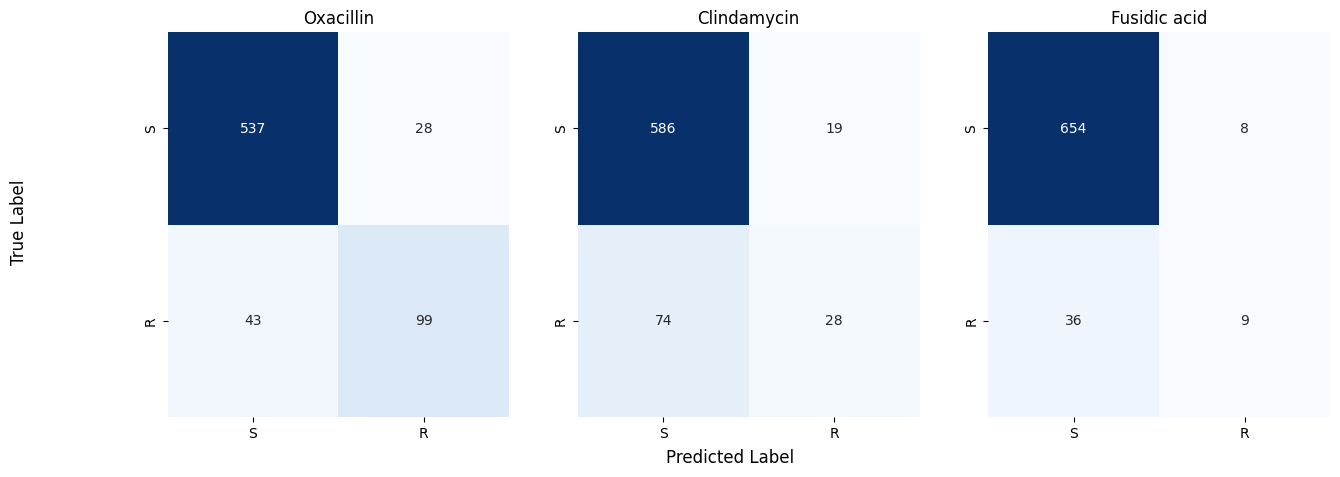

In [16]:
fig, axes = plt.subplots(1, len(antibiotics), figsize=(len(antibiotics)*5, 5))
fig.supxlabel("Predicted Label")
fig.supylabel("True Label")

cm_svm_c = multilabel_confusion_matrix(test_y, pred)

for i in range(len(antibiotics)):
  sns.heatmap(ax=axes[i], data=cm_svm_c[i], annot=True, fmt='d', cbar=None, cmap="Blues", xticklabels=["S", "R"], yticklabels=["S", "R"]).set(title=antibiotics[i])

In [17]:
calibrated_model = CalibratedClassifierCV(SVC(), cv=5)
calibrated_model.fit(train_x, train_y["Oxacillin"])

CalibratedClassifierCV(cv=5, estimator=SVC())

In [18]:
proba = calibrated_model.predict_proba(test_x)

In [19]:
proba

array([[0.87555925, 0.12444075],
       [0.87514187, 0.12485813],
       [0.8872857 , 0.1127143 ],
       ...,
       [0.69502855, 0.30497145],
       [0.57862472, 0.42137528],
       [0.79770227, 0.20229773]])

In [20]:
    antibiotic = 0
    count_tp = 0
    count_tn = 0
    count_fp = 0
    count_fn = 0
    sum_tp = 0
    sum_tn = 0
    sum_fp = 0
    sum_fn = 0
    for i in range(len(proba[:, antibiotic])):
        disc_pred = int(proba[i, antibiotic] > 0.5)
        if disc_pred == 1:
            if disc_pred == test_y.iloc[i, antibiotic]:
                count_tp += 1
                sum_tp += proba[i, antibiotic]
            else:
                count_fp += 1
                sum_fp += proba[i, antibiotic]
        else:
            if disc_pred == test_y.iloc[i, antibiotic]:
                count_tn += 1
                sum_tn += proba[i, antibiotic]
            else:
                count_fn += 1
                sum_fn += proba[i, antibiotic]
    print("Results for antibiotic", antibiotics[antibiotic])
    if count_tp == 0:
        print(" Mean TP: None")
    else: 
        print(" Mean TP:", sum_tp/count_tp)
    if count_tn == 0:
        print(" Mean TN: None")
    else: 
        print(" Mean TN:", sum_tn/count_tn)
    if count_fp == 0:
        print(" Mean FP: None")
    else: 
        print(" Mean FP:", sum_fp/count_fp)
    if count_fn == 0:
        print(" Mean FN: None")
    else: 
        print(" Mean FN:", sum_fn/count_fn)


Results for antibiotic Oxacillin
 Mean TP: 0.740168490873598
 Mean TN: 0.32439971075266305
 Mean FP: 0.8754570768148515
 Mean FN: 0.2194587934028508
